##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Integrated gradients

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/inception_v1/classification/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial demonstrates how to implement **Integrated Gradients (IG)**, an [Explainable AI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) technique introduced in the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365). IG aims to explain the relationship between a model's predictions in terms of its features. It has many use cases including understanding feature importances, identifying data skew, and debugging model performance.

IG has become a popular interpretability technique due to its broad applicability to any differentiable model (e.g. images, text, structured data), ease of implementation, theoretical justifications, and computational efficiency relative to alternative approaches that allow it to scale to large networks and feature spaces such as images.

In this tutorial, you will walk through an implementation of IG step-by-step to understand the pixel feature importances of an image classifier. As an example, consider this [image](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg) of a fireboat spraying jets of water. You would classify this image as a fireboat and might highlight the pixels making up the boat and water cannons as being important to your decision. Your model will also classify this image as a fireboat later on in this tutorial; however, does it highlight the same pixels as important when explaining its decision?

In the images below titled "IG Attribution Mask" and "Original + IG Mask Overlay" you can see that your model instead highlights (in purple) the pixels comprising the boat's water cannons and jets of water as being more important than the boat itself to its decision. How will your model generalize to new fireboats? What about fireboats without water jets? Read on to learn more about how IG works and how to apply IG to your models to better understand the relationship between their predictions and underlying features.

![Output Image 1](images/IG_fireboat.png)

## Setup

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

/Users/eneas/anaconda3/envs/tf312-1-OK/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


### Download a pretrained image classifier from TF-Hub

IG can be applied to any differentiable model. In the spirit of the original paper, you will use a pre-trained version of the same model, Inception V1, which you will download from [TensorFlow Hub](https://tfhub.dev/google/imagenet/inception_v1/classification/4).

In [3]:
model = hub.KerasLayer(
"https://tfhub.dev/google/imagenet/inception_v1/classification/4",
input_shape=(224, 224, 3),
trainable=False
)
#model.summary()

2025-07-12 15:19:54.855992: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-07-12 15:19:54.856018: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-07-12 15:19:54.856022: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
I0000 00:00:1752347994.856038  328569 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752347994.856058  328569 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


From the module page, you need to keep in mind the following about Inception V1:

**Inputs**: The expected input shape for the model is `(None, 224, 224, 3)`. This is a dense 4D tensor of dtype float32 and shape `(batch_size, height, width, RGB channels)` whose elements are RGB color values of pixels normalized to the range [0, 1]. The first element is `None` to indicate that the model can take any integer batch size.

**Outputs**: A `tf.Tensor` of logits in the shape of `(batch_size, 1001)`. Each row represents the model's predicted score for 1,001 classes from ImageNet. For the model's top predicted class index you can use `tf.math.argmax(predictions, axis=-1)`. Furthermore, you can also convert the model's logit output to predicted probabilities across all classes using `tf.nn.softmax(predictions, axis=-1)` to quantify the model's uncertainty and explore similar predicted classes for debugging.

In [4]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [5]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

### Load and preprocess images with `tf.image`

You will illustrate IG using two images from [Wikimedia Commons](https://commons.wikimedia.org/wiki/Main_Page): a [Fireboat](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg), and a [Giant Panda](https://commons.wikimedia.org/wiki/File:Giant_Panda_2.JPG).

In [6]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [7]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    'coyote': 'https://upload.wikimedia.org/wikipedia/commons/c/ce/Canis_latrans_%28Yosemite%2C_2009%29.jpg'
}
img_paths = {name: tf.keras.utils.get_file(f"{name}.jpg", url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

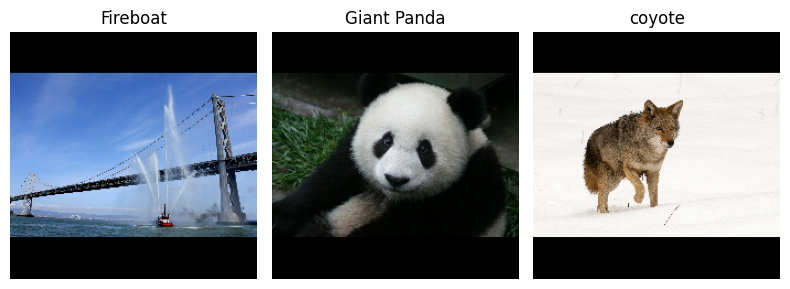

In [8]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 3, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()
plt.savefig('images/inception_v1_input.jpg', dpi=300)

### Classify images
Start by classifying these images and displaying the top 3 most confident predictions. The following is a utility function to retrieve the top k predicted labels and probabilities.

In [9]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

2025-07-12 15:19:55.790648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%
giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%
coyote: 90.1%
timber wolf: 5.4%
grey fox: 1.7%


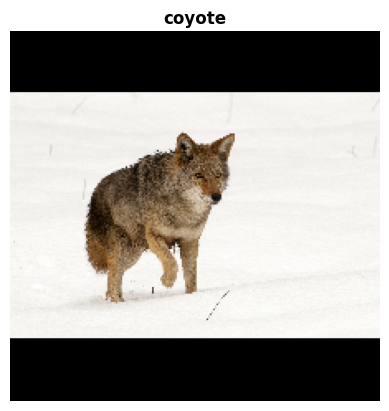

In [10]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  #plt.show(block=False)
  plt.savefig(f'images/inception_v1_{name}.jpg', dpi=300)
  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## Calculate Integrated Gradients

Your model, Inception V1, is a learned function that describes a mapping between your input feature space, image pixel values, and an output space defined by ImageNet class probability values between 0 and 1. Early interpretability methods for neural networks assigned feature importance scores using gradients, which tell you which pixels have the steepest local relative to your model's prediction at a given point along your model's prediction function. However, gradients only describe *local* changes in your model's prediction function with respect to pixel values and do not fully describe your entire model prediction function. As your model fully "learns" the relationship between the range of an individual pixel and the correct ImageNet class, the gradient for this pixel will *saturate*, meaning become increasingly small and even go to zero. Consider the simple model function below:

In [11]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

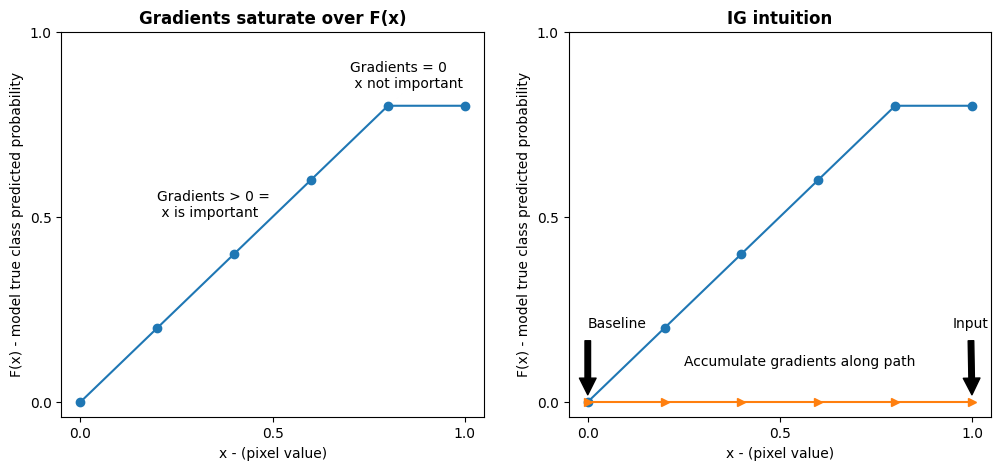

In [12]:
#@title
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.savefig('images/integrated_gradients_intuition.jpg', dpi=300)
plt.show(block=False)


* **left**: Your model's gradients for pixel `x` are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. Pixel `x` clearly has a significant impact on pushing your model toward 80% predicted probability on the true class. *Does it make sense that pixel `x`'s importance is small or discontinuous?*

* **right**: The intuition behind IG is to accumulate pixel `x`'s local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability. You can break down and compute IG in 3 parts: 
  1. interpolate small steps along a straight line in the feature space between 0 (a baseline or starting point) and 1 (input pixel's value) 
  2. compute gradients at each step between your model's predictions with respect to each step 
  3. approximate the integral between your baseline and input by accumulating (cumulative average) these local gradients.

To reinforce this intuition, you will walk through these 3 parts by applying IG to the example "Fireboat" image below. 

### Establish a baseline

A baseline is an input image used as a starting point for calculating feature importance. Intuitively, you can think of the baseline's explanatory role as representing the impact of the absence of each pixel on the "Fireboat" prediction to contrast with its impact of each pixel on the "Fireboat" prediction when present in the input image. As a result, the choice of the baseline plays a central role in interpreting and visualizing pixel feature importances. For additional discussion of baseline selection, see the resources in the "Next steps" section at the bottom of this tutorial. Here, you will use a black image whose pixel values are all zero.

Other choices you could experiment with include an all white image, or a random image, which you can create with `tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)`.

In [13]:
baseline = tf.zeros(shape=(224,224,3))

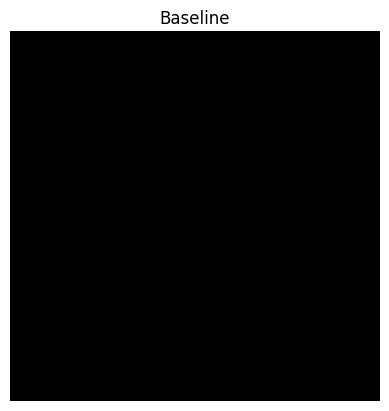

In [14]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
#plt.show(block=False)
plt.savefig('images/integrated_gradients_baseline.jpg', dpi=300)

### Unpack formulas into code

The formula for Integrated Gradients is as follows:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input  
$x'$ = baseline   
$\alpha$ = interpolation constant to perturb features by

In practice, computing a definite integral is not always numerically possible and can be computationally costly, so you compute the following numerical approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$_{i}$ = feature (individual pixel)  
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$k$ = scaled feature perturbation constant  
$m$ = number of steps in the Riemann sum approximation of the integral  
$(x_{i}-x'_{i})$ = a term for the difference from the baseline. This is necessary to scale the integrated gradients and keep them in terms of the original image. The path from the baseline image to the input is in pixel space. Since with IG you are integrating in a straight line (linear transformation) this ends up being roughly equivalent to the integral term of the derivative of the interpolated image function with respect to $\alpha$ with enough steps. The integral sums each pixel's gradient times the change in the pixel along the path. It's simpler to implement this integration as uniform steps from one image to the other, substituting $x := (x' + \alpha(x-x'))$. So the change of variables gives $dx = (x-x')d\alpha$. The $(x-x')$ term is constant and is factored out of the integral.

### Interpolate images

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

First, you will generate a [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) between the baseline and the original image. You can think of interpolated images as small steps in the feature space between your baseline and input, represented by $\alpha$ in the original equation.

In [15]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [16]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

Use the above function to generate interpolated images along a linear path at alpha intervals between a black baseline image and the example "Fireboat" image.

In [17]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

Visualize the interpolated images. Note: another way of thinking about the $\alpha$ constant is that it is consistently increasing each interpolated image's intensity.

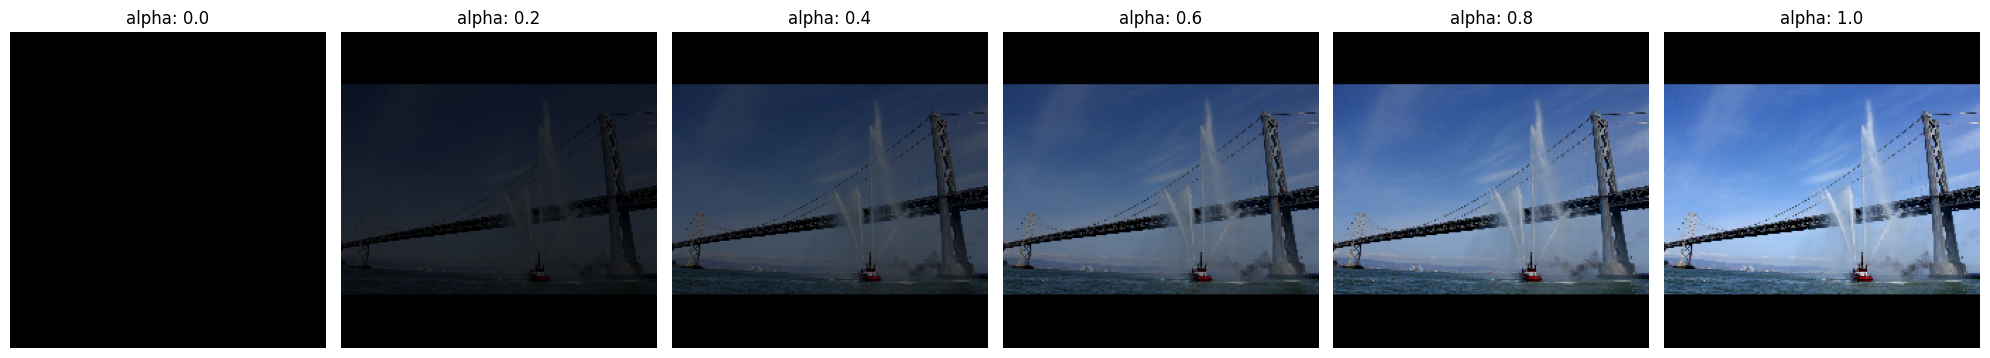

In [18]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()
plt.savefig('images/integrated_gradients_interpolated.jpg', dpi=300)

### Compute gradients

This section explains how to calculate the gradients to measure the relationship between changes to a feature and changes in the model's predictions. In the case of images, the gradient tells us which pixels have the strongest effect on the model's predicted class probabilities.

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

where:  
$F()$ = your model's prediction function  
$\frac{\partial{F}}{\partial{x_i}}$ = gradient (vector of partial derivatives $\partial$) of your model F's prediction function relative to each feature $x_i$

TensorFlow makes computing gradients easy for you with a [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

In [19]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

Compute the gradients for each image along the interpolation path with respect to the correct output. Recall that your model returns a `(1, 1001)` shaped `Tensor` with logits that you convert to predicted probabilities for each class. You need to pass the correct ImageNet target class index to the `compute_gradients` function for your image.

In [20]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

Note the output shape of `(n_interpolated_images, img_height, img_width, RGB)`, which gives us the gradient for every pixel of every image along the interpolation path. You can think of these gradients as measuring the change in your model's predictions for each small step in the feature space.

In [21]:
print(path_gradients.shape)

(51, 224, 224, 3)


**Visualizing gradient saturation**

Recall that the gradients you just calculated above describe *local* changes to your model's predicted probability of "Fireboat" and can *saturate*.

These concepts are visualized using the gradients you calculated above in the 2 plots below.

In [22]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

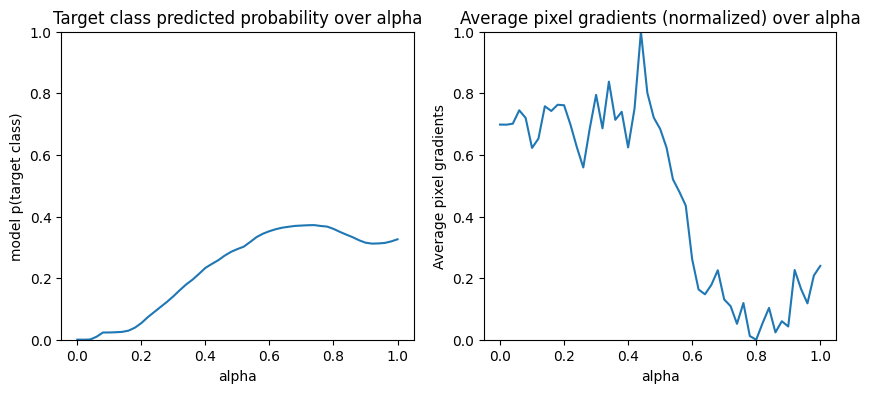

In [23]:
#@title
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g., (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1])
plt.savefig('images/integrated_gradients_gradients.jpg', dpi=300)

* **left**: This plot shows how your model's confidence in the "Fireboat" class varies across alphas. Notice how the gradients, or slope of the line, largely flattens or saturates between 0.6 and 1.0 before settling at the final "Fireboat" predicted probability of about 40%.

* **right**: The right plot shows the average gradients magnitudes over alpha more directly. Note how the values sharply approach and even briefly dip below zero. In fact, your model "learns" the most from gradients at lower values of alpha before saturating. Intuitively, you can think of this as your model has learned the pixels e.g. water cannons to make the correct prediction, sending these pixel gradients to zero, but is still quite uncertain and focused on spurious bridge or water jet pixels as the alpha values approach the original input image.

To make sure these important water cannon pixels are reflected as important to the "Fireboat" prediction, you will continue on below to learn how to accumulate these gradients to accurately approximate how each pixel impacts your "Fireboat" predicted probability.


### Accumulate gradients (integral approximation)

There are many different ways you can go about computing the numerical approximation of an integral for IG with different tradeoffs in accuracy and convergence across varying functions. A popular class of methods is called [Riemann sums](https://en.wikipedia.org/wiki/Riemann_sum). Here, you will use the Trapezoidal rule (you can find additional code to explore different approximation methods at the end of this tutorial).

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{Sum m local gradients}\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

From the equation, you can see you are summing over `m` gradients and dividing by `m` steps. You can implement the two operations together for part 3 as an *average of the local gradients of `m` interpolated predictions and input images*.

In [24]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

The `integral_approximation` function takes the gradients of the predicted probability of the target class with respect to the interpolated images between the baseline and the original image.

In [25]:
ig = integral_approximation(
    gradients=path_gradients)

You can confirm averaging across the gradients of `m` interpolated images returns an integrated gradients tensor with the same shape as the original "Giant Panda" image.

In [26]:
print(ig.shape)

(224, 224, 3)


### Putting it all together

Now you will combine the 3 previous general parts together into an `IntegratedGradients` function and utilize a [@tf.function](https://www.tensorflow.org/guide/function) decorator to compile it into a high performance callable TensorFlow graph. This is implemented as 5 smaller steps below:


$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [27]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx) # type: ignore
    gradient_batches.append(gradient_batch)
      
  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [28]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [29]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

Again, you can check that the IG feature attributions have the same shape as the input "Fireboat" image.

In [30]:
print(ig_attributions.shape)

(224, 224, 3)


The paper suggests the number of steps to range between 20 to 300 depending upon the example (although in practice this can be higher in the 1,000s to accurately approximate the integral). You can find additional code to check for the appropriate number of steps in the "Next steps" resources at the end of this tutorial.

### Visualize attributions

You are ready to visualize attributions, and overlay them on the original image. The code below sums the absolute values of the integrated gradients across the color channels to produce an attribution mask. This plotting method captures the relative impact of pixels on the model's predictions. 

In [31]:
#@title
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

Looking at the attributions on the "Fireboat" image, you can see the model identifies the water cannons and spouts as contributing to its correct prediction.

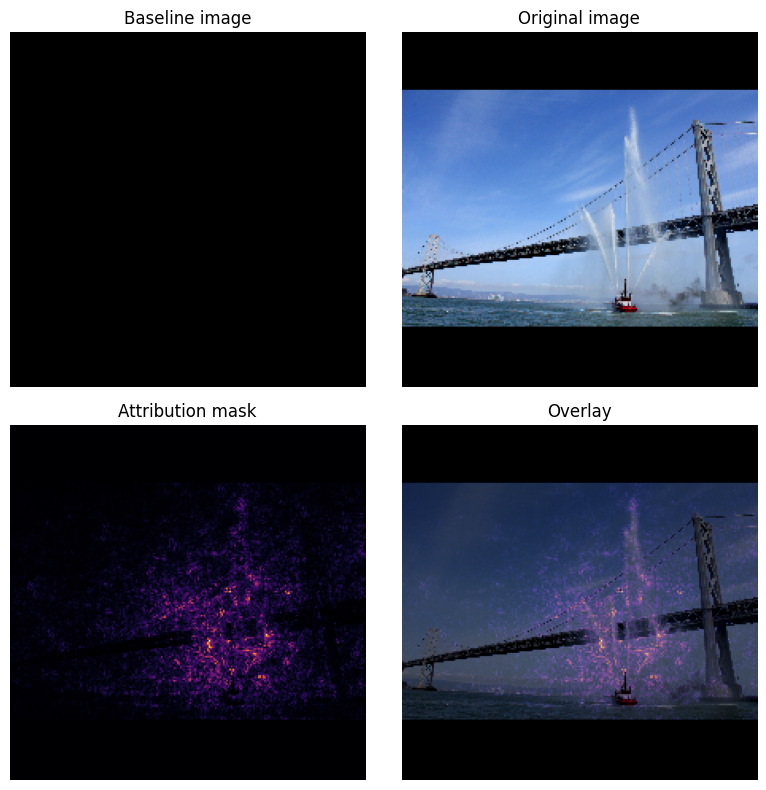

In [32]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)
plt.savefig('images/integrated_gradients_fireboat.jpg', dpi=300)

On the "Giant Panda" image, the attributions highlight the texture, nose, and the fur of the Panda's face.

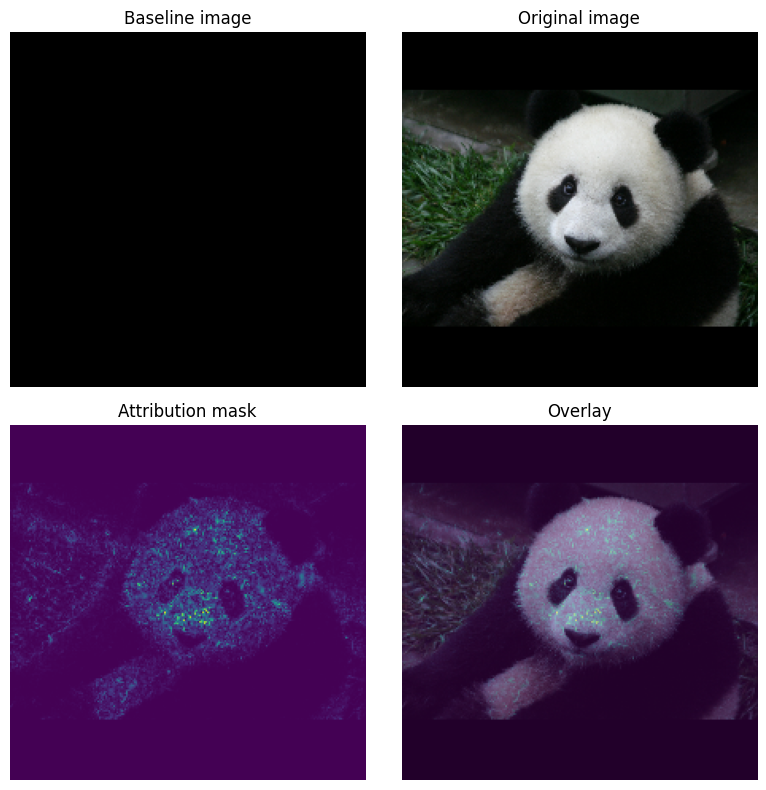

In [33]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],baseline=baseline, target_class_idx=389,m_steps=55,cmap=plt.cm.viridis,
                          overlay_alpha=0.5)
plt.savefig('images/integrated_gradients_giant_panda.jpg', dpi=300)

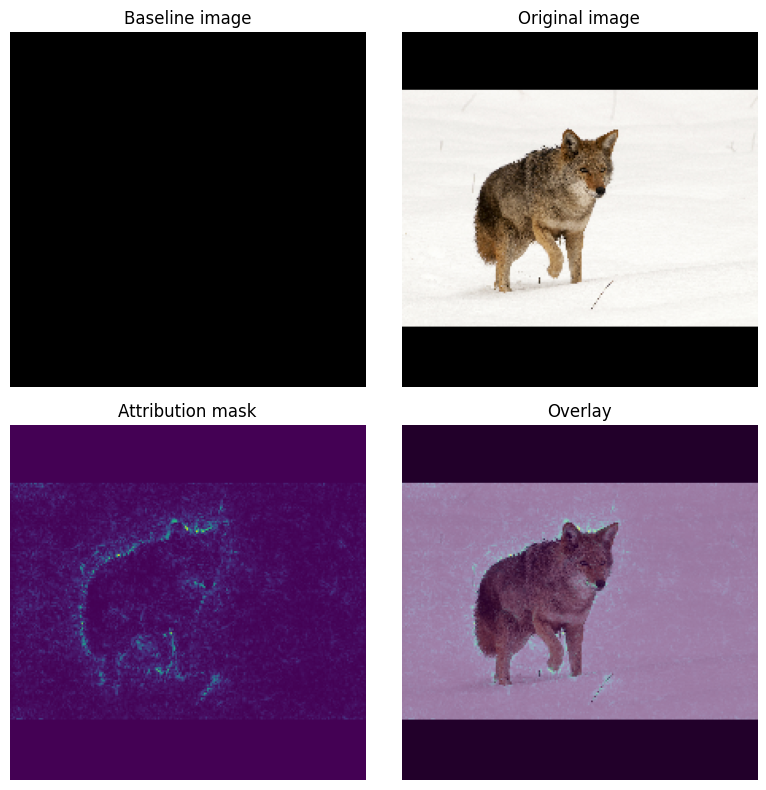

In [34]:
_ = plot_img_attributions(image=img_name_tensors['coyote'],baseline=baseline, target_class_idx=389,m_steps=55,cmap=plt.cm.viridis,
                          overlay_alpha=0.5)
plt.savefig('images/integrated_gradients_coyote.jpg', dpi=300)

## Uses and limitations

Use cases
* Employing techniques like Integrated Gradients before deploying your model can help you develop intuition for how and why it works. Do the features highlighted by this technique match your intuition? If not, that may be indicative of a bug in your model or dataset, or overfitting.

Limitations
* The Integrated Gradients technique provides feature importances on individual examples. However, it does not provide global feature importances across an entire dataset.

* The Integrated Gradients technique provides individual feature importances, but it does not explain feature interactions and combinations.

## Next steps

This tutorial presented a basic implementation of Integrated Gradients. As a next step, you can use this notebook to try this technique with different models and images yourself.

For interested readers, there is a lengthier version of this tutorial (which includes code for different baselines, to compute integral approximations, and to determine a sufficient number of steps) which you can find [here](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/blogs/integrated_gradients).

To deepen your understanding, check out the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) and [Github repository](https://github.com/ankurtaly/Integrated-Gradients), which contains an implementation in a previous version of TensorFlow. You can also explore feature attribution, and the impact of different baselines, on [distill.pub](https://distill.pub/2020/attribution-baselines/).

Interested in incorporating IG into your production machine learning workflows for feature importances, model error analysis, and data skew monitoring? Check out Google Cloud's [Explainable AI](https://cloud.google.com/explainable-ai) product that supports IG attributions. The Google AI PAIR research group also open-sourced the [What-if tool](https://pair-code.github.io/what-if-tool/index.html#about) which can be used for model debugging, including visualizing IG feature attributions.